In [1]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.metrics import make_scorer, cohen_kappa_score
path = '../input/child-mind-institute-problematic-internet-use/'

train = pd.read_csv(path + 'train.csv', index_col = 'id')
print("The train data has the shape: ",train.shape)
test = pd.read_csv(path + 'test.csv', index_col = 'id')
print("The test data has the shape: ",test.shape)
print("")
print("Total number of missing training values: ", train.isna().sum().sum())
train_cat_columns = train.select_dtypes(exclude = 'number').columns

for season in train_cat_columns:
    train[season] = train[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})
PCIAT_cols = [val for val in train.columns[train.columns.str.contains('PCIAT')]]
PCIAT_cols.remove('PCIAT-PCIAT_Total')
train = train.drop(columns = PCIAT_cols)
train = train.dropna(subset='sii')

The train data has the shape:  (3960, 81)
The test data has the shape:  (20, 58)

Total number of missing training values:  131717


/tmp/ipykernel_17/1953905051.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[season] = train[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})


In [2]:
def split_data(data,ratio=0.7):
    train_model=[]
    train_val=[]
    for sii in range(4):
        
        train_model.append(train[train.sii==sii][:round(len(train[train.sii==sii])*ratio)])
        train_val.append(train[train.sii==sii][round(len(train[train.sii==sii])*ratio):])
        print(sii)
    
    return pd.concat(train_model),pd.concat(train_val)
train_model,train_val=split_data(train,ratio=0.9)

0
1
2
3


Text(0.5, 1.0, 'Count of sii in training model')

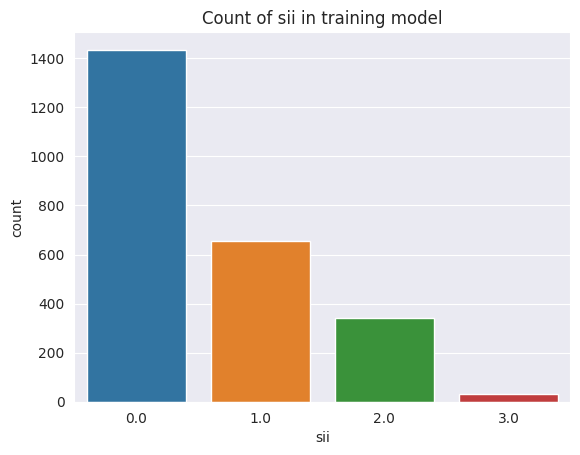

In [3]:
sns.countplot(train_model, x = 'sii').set_title('Count of sii in training model')

Text(0.5, 1.0, 'Count of sii in validation')

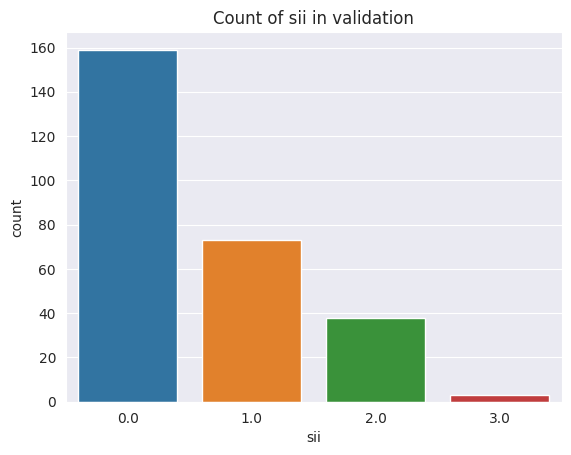

In [4]:
sns.countplot(train_val, x = 'sii').set_title('Count of sii in validation')

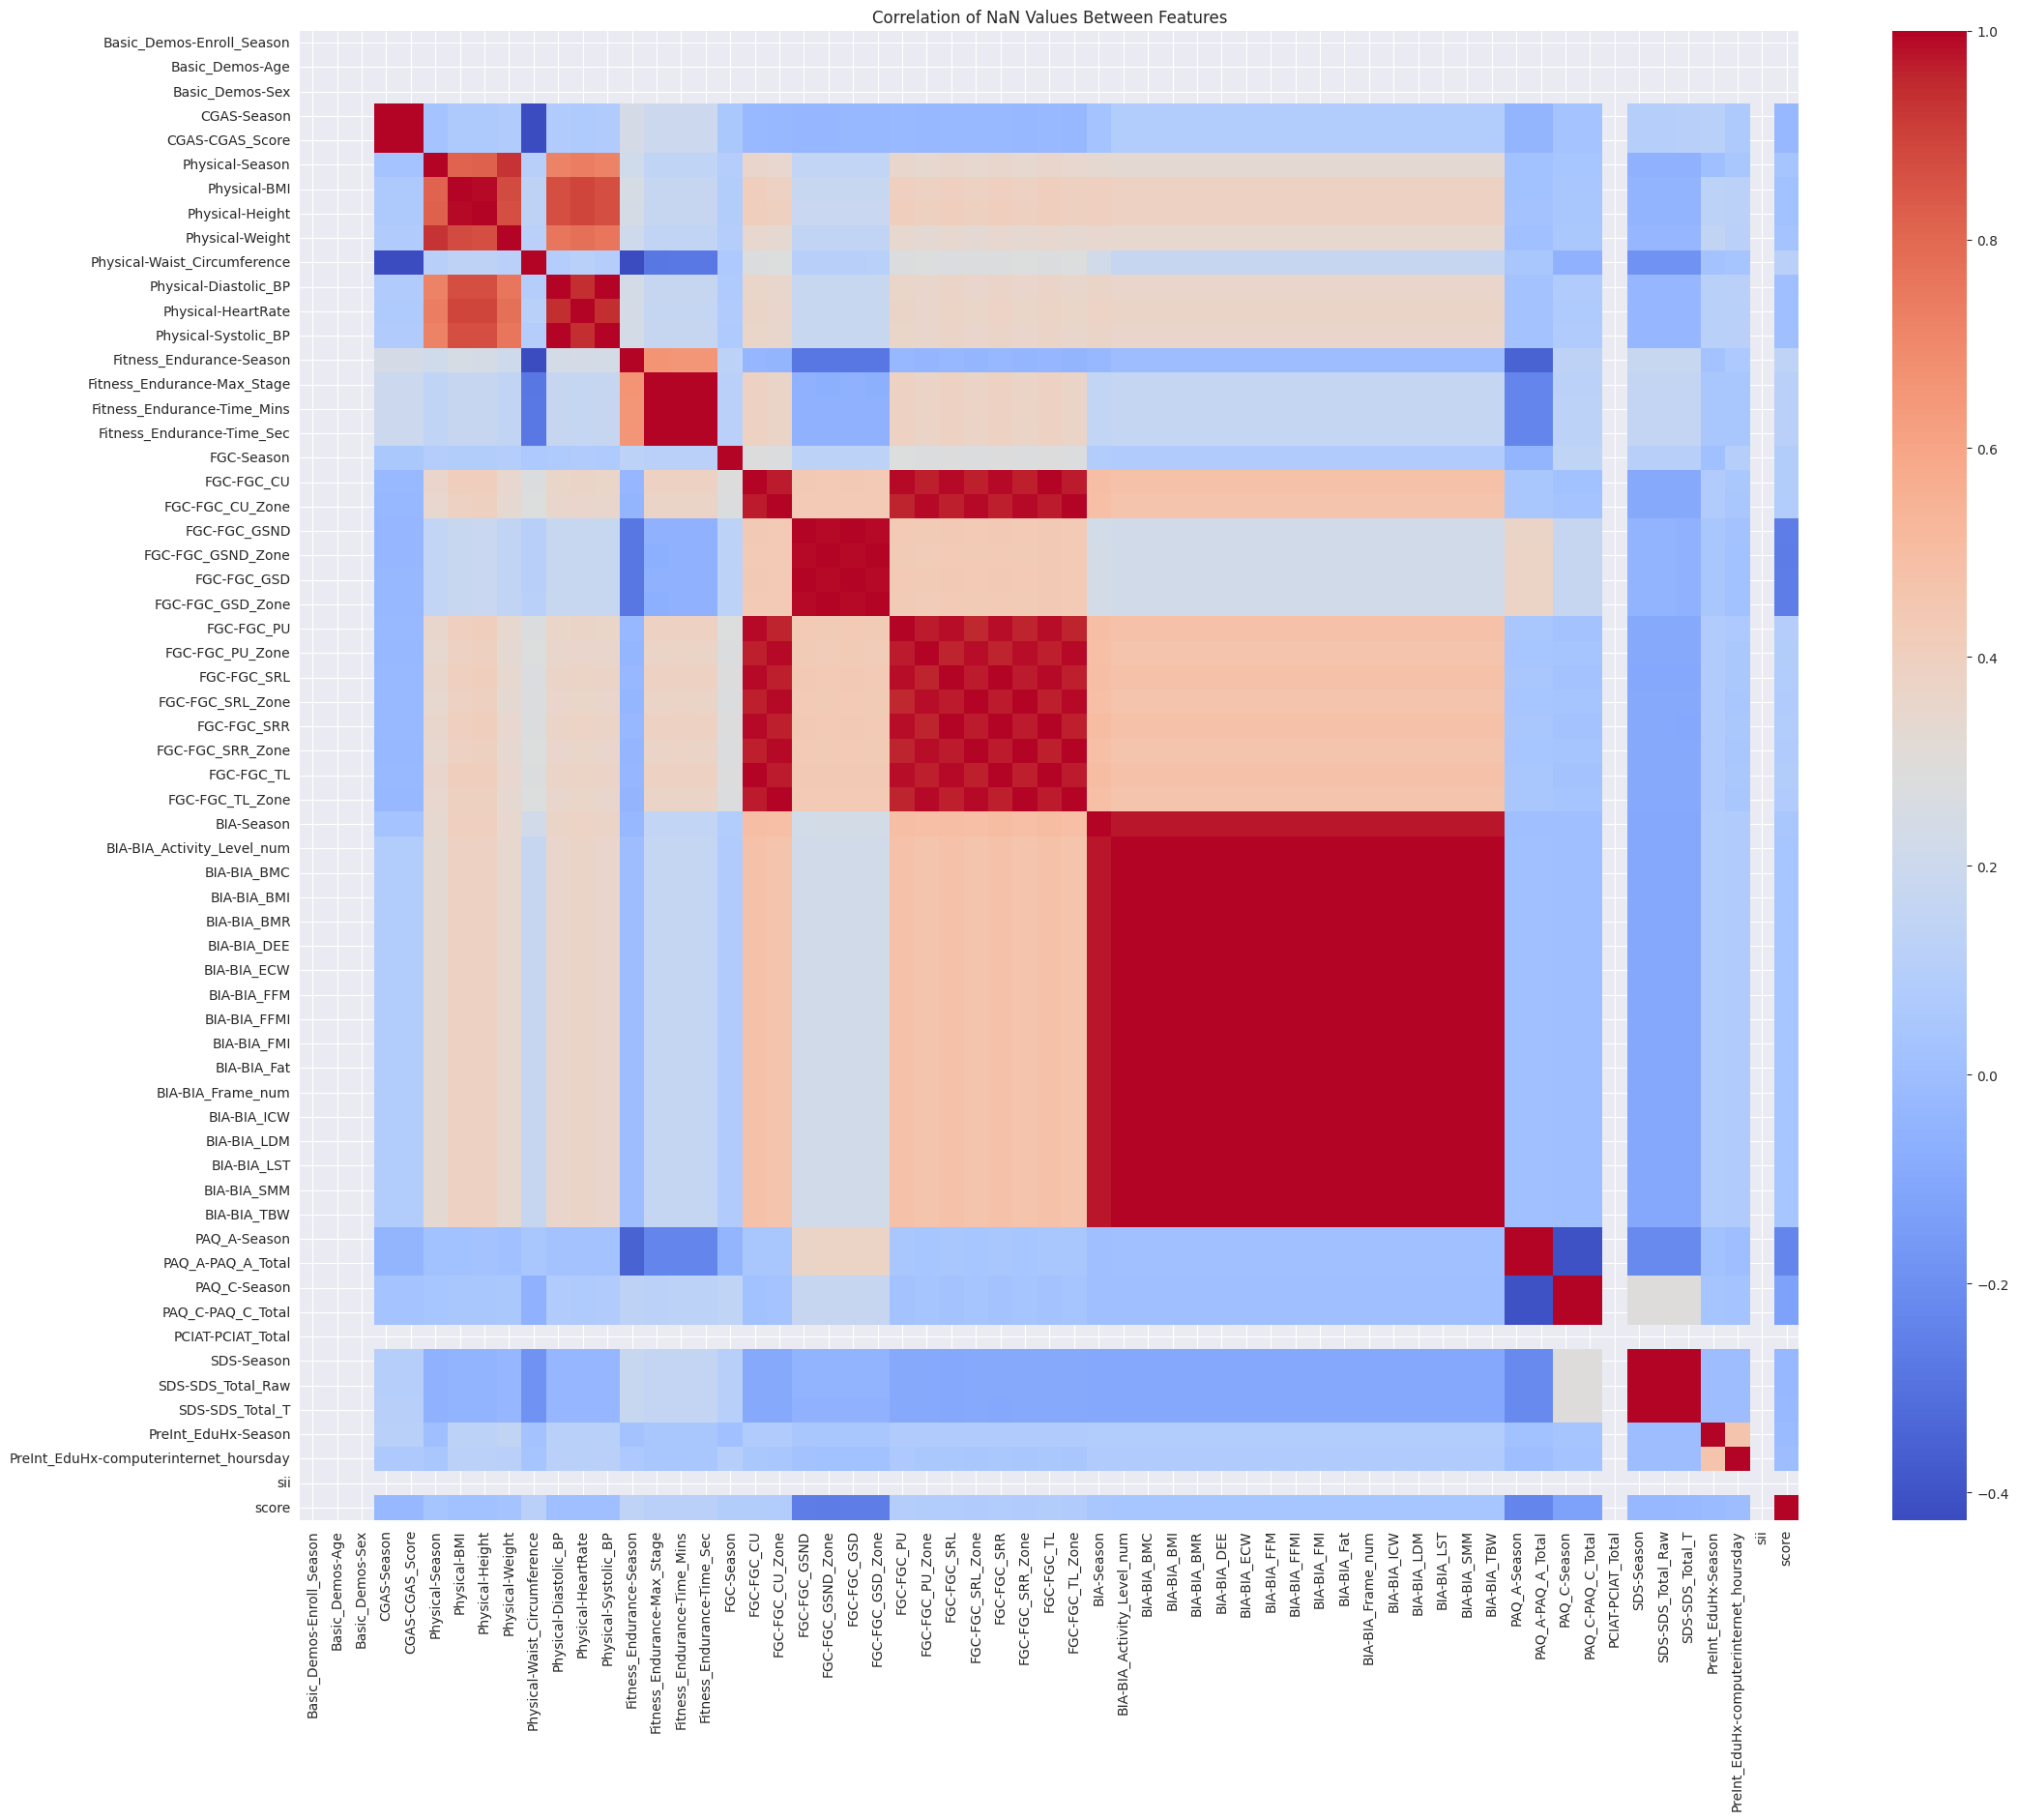

In [5]:
def nan_correlation(df):
    # Create a binary mask where NaN = 1 and non-NaN = 0
    nan_mask = df.isna().astype(int)
    nan_mask['score']=df['PCIAT-PCIAT_Total']
    # Calculate the correlation matrix for NaN occurrences
    nan_corr = nan_mask.corr()
    
    return nan_corr
nan_corr=nan_correlation(train_model)
# Plot the correlation matrix using seaborn
plt.figure(figsize=(25, 20))
sns.heatmap(nan_corr, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation of NaN Values Between Features")
plt.show()


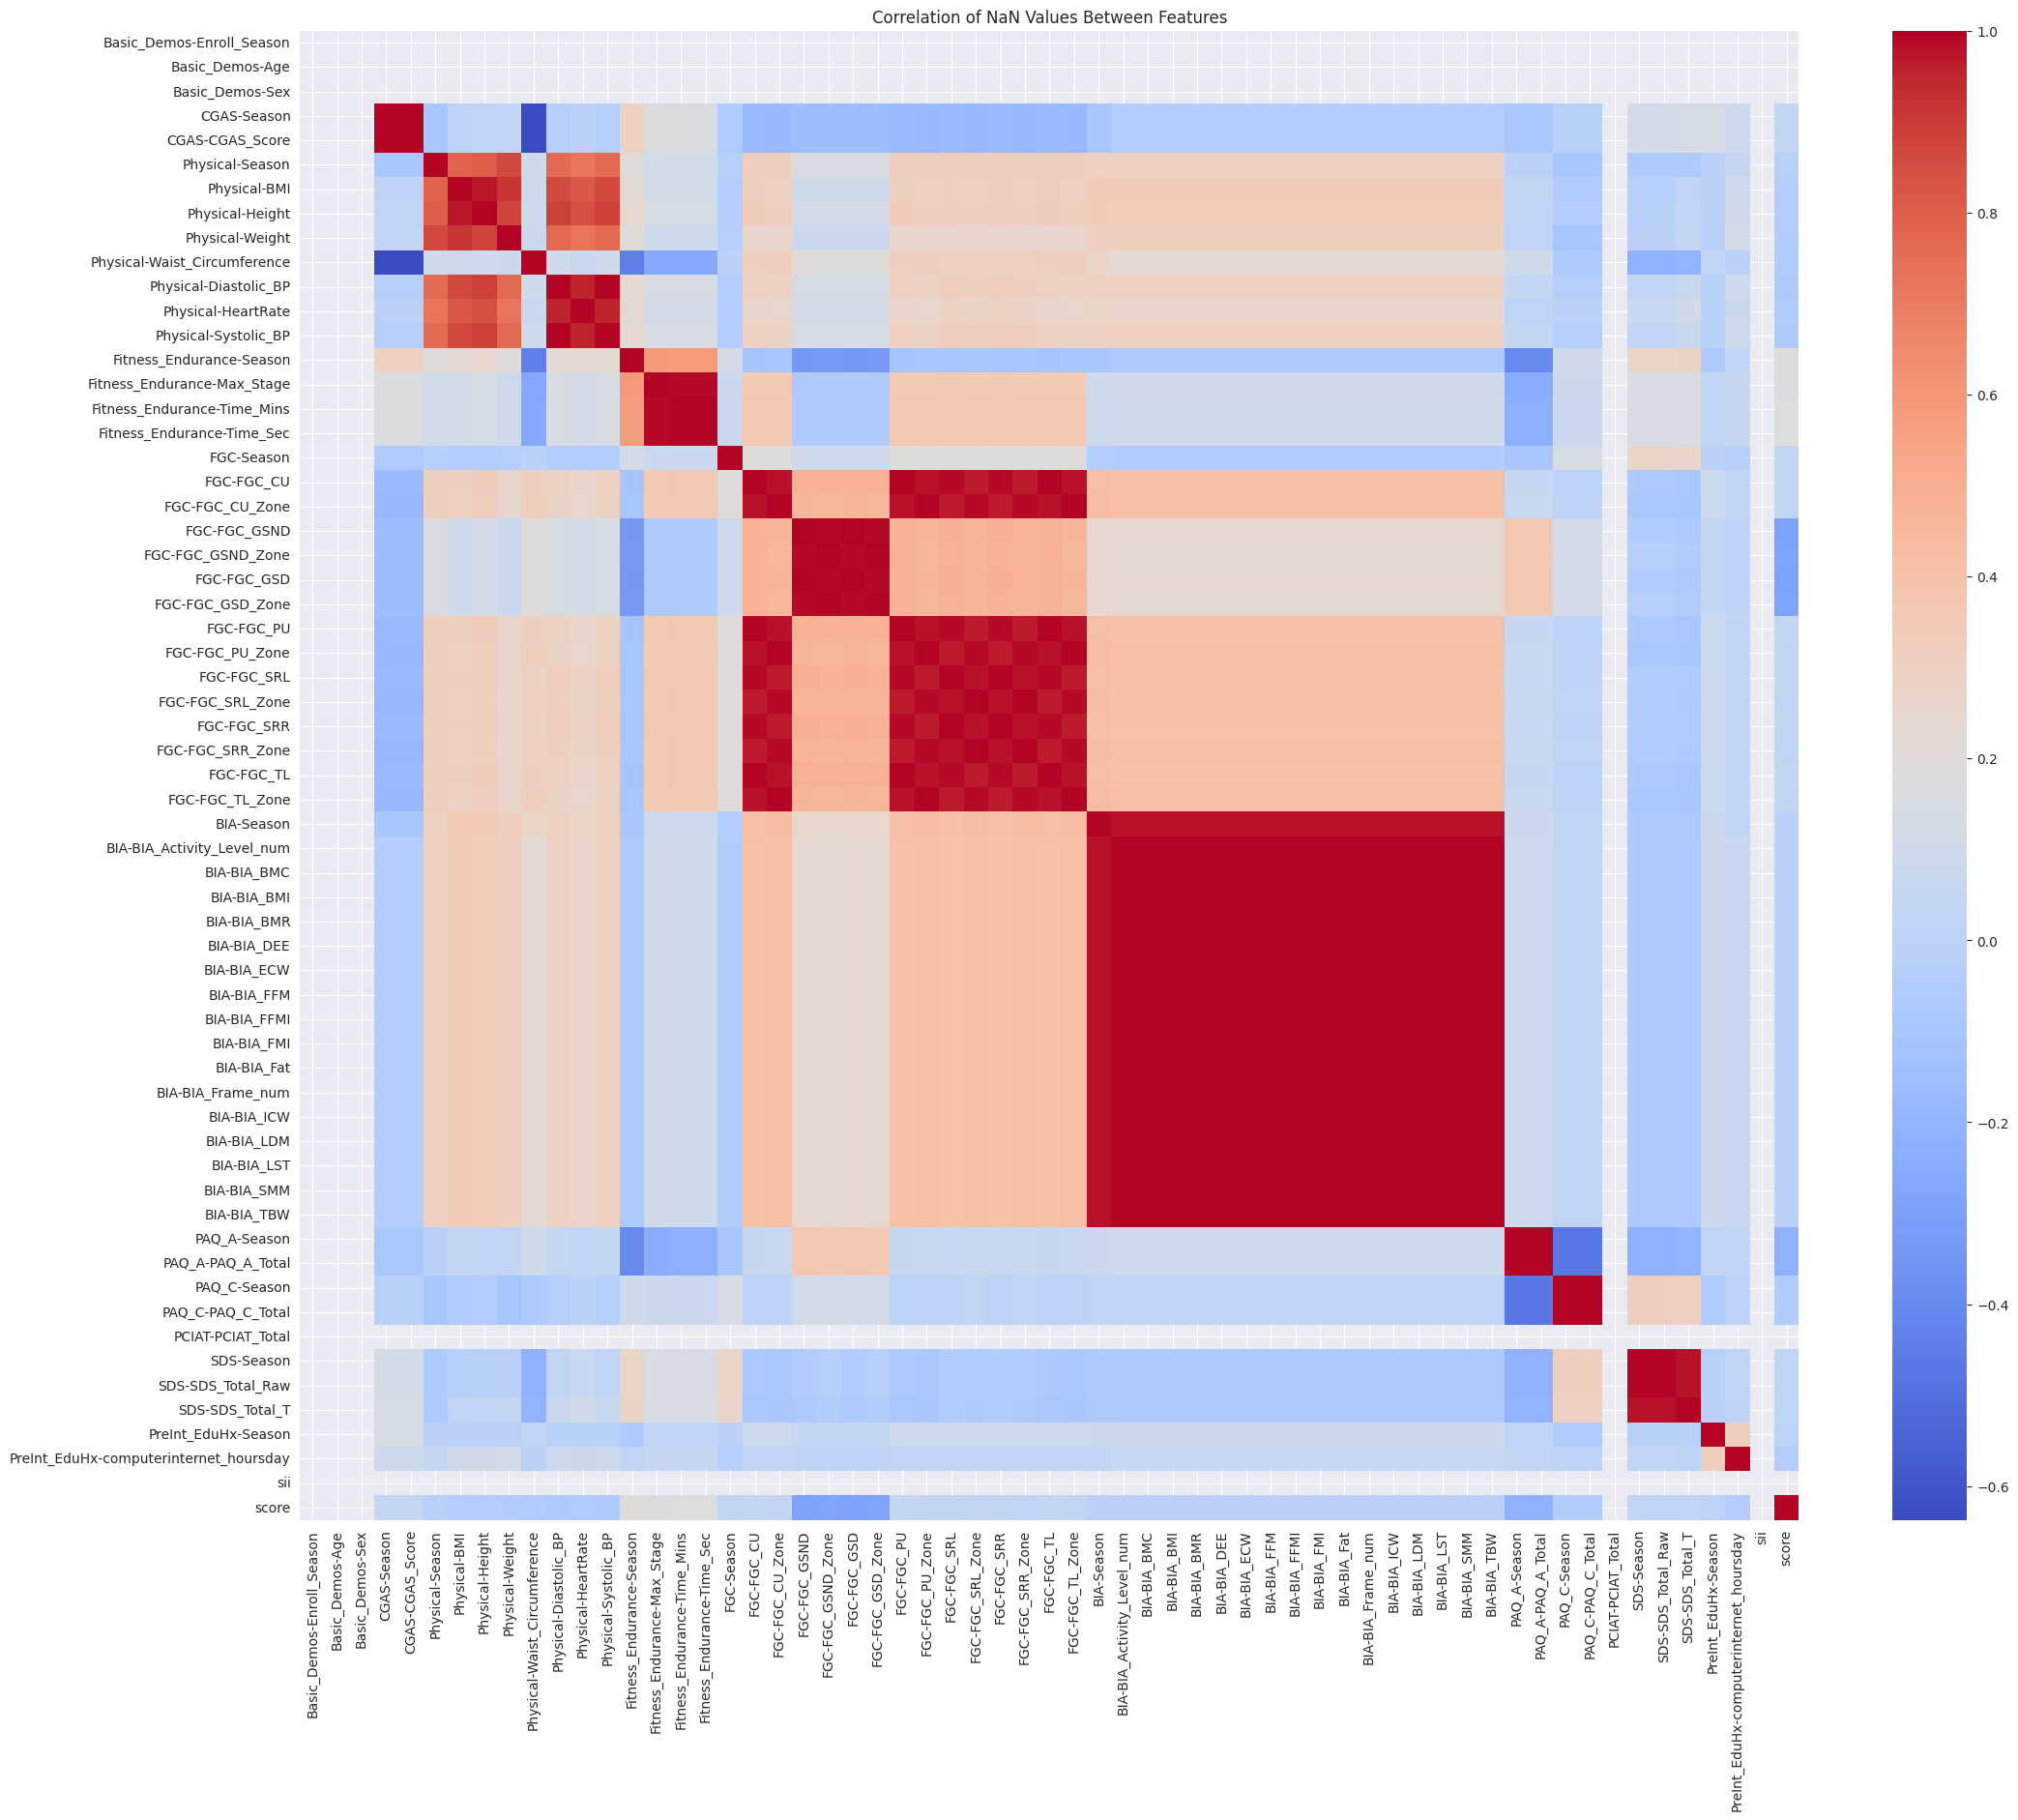

In [6]:
def nan_correlation(df):
    # Create a binary mask where NaN = 1 and non-NaN = 0
    nan_mask = df.isna().astype(int)
    nan_mask['score']=df['PCIAT-PCIAT_Total']
    # Calculate the correlation matrix for NaN occurrences
    nan_corr = nan_mask.corr()
    
    return nan_corr
nan_corr=nan_correlation(train_val)
# Plot the correlation matrix using seaborn
plt.figure(figsize=(25, 20))
sns.heatmap(nan_corr, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation of NaN Values Between Features")
plt.show()


# Ensemble of different categories

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
categories = {
        "Basic": ["Basic_Demos"],
        "CGAS": ["CGAS"],
        "Physical": ["Physical"],
        "SDS": ["SDS"],
        "PreInt_EduHx": ["PreInt_EduHx"],
        "BIA": ["BIA"],
        "Fitness_Endurance":["Fitness_Endurance"]
        
    }
def convert(scores):
    scores = np.array(scores)*1.3
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins
def quadratic_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
def separate_data_by_category(df):
    # Define the categories and the prefixes corresponding to each category
    

    # Create empty dictionaries to store data for each category
    separated_data = {category: pd.DataFrame() for category in categories}

    # Iterate over each column and categorize them based on the prefix
    for column in df.columns:
        for category, prefixes in categories.items():
            if any(column.startswith(prefix) for prefix in prefixes):
                separated_data[category][column] = df[column]
    
    for category in separated_data:
            separated_data[category].dropna(inplace=True)
    return separated_data



def weighted_mse_loss(y_pred, y_true, weights):
    return torch.mean(weights * (y_pred - y_true) ** 2)


unique_values, counts = torch.unique(torch.tensor(train_model.sii.values), return_counts=True)

weights_dict = {val.item(): 1-count.item()/sum(counts) for val, count in zip(unique_values, counts)}
print("Weights for each target value:", weights_dict)

# Step 3: Assign weights to each sample based on their target value
weights = torch.tensor([weights_dict[val.item()] for val in train_model.sii.values], dtype=torch.float)






# Define a custom dataset class that handles sample IDs from the index
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)
        self.sample_ids = data.index  # Use the index as sample IDs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx], self.sample_ids[idx]

# Simple Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        return self.network(x) * 100
# Function to train multiple NNs, one per category
def train_multiple_nns(separated_data, target_df, num_epochs=100, batch_size=32, lr=0.001):
    models = {}
    optimizers = {}
    losses = {}

    # Loss function (assuming regression task, modify for classification)
    criterion = nn.MSELoss()

    # Store predictions and sample IDs for mapping later
    all_predictions = {}

    for category, data in separated_data.items():
        print(category)
        if category== 'PAQ':
            continue
        # Extract targets matching the sample IDs in separated_data
        matching_targets = target_df.loc[data.index]  # Ensure target_df index aligns with data.index
        
        # Create dataset and data loader
        dataset = CustomDataset(data, matching_targets)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize model, optimizer, and store them
        input_size = data.shape[1]
        model = SimpleNN(input_size)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for inputs, target, ids in dataloader:
                optimizer.zero_grad()
                output = model(inputs).squeeze()
                weights = torch.tensor([weights_dict[val.item()] for val in convert(target)], dtype=torch.float)
                loss = criterion(output, target)
                
                loss.backward()
                optimizer.step()
        
        print(loss)
        
        # Inference for this category (store sample IDs and predictions)
        model.eval()
        predictions = []
        ids_collected = []
        with torch.no_grad(): 
                output = model(inputs).squeeze()
                predictions.extend(output.numpy())
                ids_collected.extend(ids)  # Keep sample IDs as strings

        models[category] = model
        optimizers[category] = optimizer
        # Store predictions for this category
        all_predictions[category] = pd.DataFrame({'Sample_ID': ids_collected, 'Prediction': predictions})
        
    return all_predictions,models

Weights for each target value: {0.0: tensor(0.4174), 1.0: tensor(0.7333), 2.0: tensor(0.8620), 3.0: tensor(0.9874)}


In [8]:
separated_data=separate_data_by_category(train_model)
targets = train_model["PCIAT-PCIAT_Total"]
predictions,models = train_multiple_nns(separated_data, targets)

Basic
tensor(149.8818, grad_fn=<MseLossBackward0>)
CGAS
tensor(500.7814, grad_fn=<MseLossBackward0>)
Physical
tensor(225.4223, grad_fn=<MseLossBackward0>)
SDS
tensor(966.1538, grad_fn=<MseLossBackward0>)
PreInt_EduHx
tensor(366.3545, grad_fn=<MseLossBackward0>)
BIA
tensor(107.7047, grad_fn=<MseLossBackward0>)
Fitness_Endurance
tensor(409.7765, grad_fn=<MseLossBackward0>)


In [9]:
def convert(scores):
    scores = np.array(scores)*1.3
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins
def quadratic_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
kappa_scores={category:quadratic_kappa(convert(targets[predictions[category]['Sample_ID'].values].values),convert(predictions[category]['Prediction'].values)) if quadratic_kappa(convert(targets[predictions[category]['Sample_ID'].values].values),convert(predictions[category]['Prediction'].values))>0 else 0  for category in categories}

kappa_scores

{'Basic': 0.3783783783783784,
 'CGAS': 0.05769230769230771,
 'Physical': 0.6944444444444444,
 'SDS': 0,
 'PreInt_EduHx': 0.2857142857142857,
 'BIA': 0,
 'Fitness_Endurance': 0.2334152334152334}

In [10]:
kappa_scores_normalize={key: value / sum(kappa_scores.values()) for key, value in kappa_scores.items()}
kappa_scores_normalize

{'Basic': 0.2293696272466225,
 'CGAS': 0.034972566791724044,
 'Physical': 0.42096608175223366,
 'SDS': 0.0,
 'PreInt_EduHx': 0.1731974736352047,
 'BIA': 0.0,
 'Fitness_Endurance': 0.14149425057421516}

In [11]:

separated_data=separate_data_by_category(train_val)


def make_predictions_for_test_data(test_data, models):
    all_predictions={}
    for category, model in models.items():
        if category in test_data:  # Only make predictions for categories with test data
            model.eval()
            test_inputs = torch.tensor(test_data[category].values, dtype=torch.float32)
            
            with torch.no_grad():
                output = model(test_inputs).squeeze()

                all_predictions[category] =pd.DataFrame({'Sample_ID': test_data[category].index, 'Prediction': output.numpy()})
    
    return all_predictions

# Function to combine the predictions as done during training
def combine_test_predictions(predictions,test):
    combined_predictions = []
    
    for sample_idx in test.index:  # Loop through each sample
        available_preds = []
        available_weights = []

        for category, preds in predictions.items():
            if not preds[preds['Sample_ID']==sample_idx].empty:  # If the prediction exists (not NaN)
                available_preds.append(preds[preds['Sample_ID']==sample_idx]['Prediction'] * kappa_scores_normalize[category])
                available_weights.append(kappa_scores_normalize[category])

        if available_weights:  # Compute weighted average if there are available predictions
            combined_predictions.append(np.sum(available_preds) / np.sum(available_weights))
        else:
            combined_predictions.append(np.nan)  # No predictions available for this sample
    result=pd.DataFrame({'Sample_ID': test.index, 'Prediction':convert(combined_predictions)})
    result.set_index('Sample_ID', inplace=True)
    return result



# Make predictions on test data for each category
test_predictions = make_predictions_for_test_data(separated_data, models)

# Combine the test predictions (same method as used during training)
final_test_predictions = combine_test_predictions(test_predictions,train_val)

In [12]:
final_test_predictions

,Prediction
Sample_ID,
e4e58096,1.0
e4ee6ff3,1.0
e5349ce2,0.0
e56b2209,0.0
e6169c6d,1.0
...,...
fe5e2dc9,0.0
feb53635,2.0
d0429481,1.0


In [13]:
targets = train_val["PCIAT-PCIAT_Total"]
kappa_scores=quadratic_kappa(convert(targets[list(final_test_predictions.index.values)].values),convert(final_test_predictions['Prediction'].values))
kappa_scores

0.0

Simple NN with Mask


In [14]:


import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class that handles sample IDs from the index
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.data = torch.nan_to_num(self.data, nan=0.0)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)
        self.sample_ids = data.index  # Use the index as sample IDs
        self.mask=np.array(data.isna().astype(int))
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx], self.sample_ids[idx],self.mask[idx]

# Simple Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        return self.network(x) * 100
# Function to train multiple NNs, one per category
def train_mask_nns(data, target_df, num_epochs=100, batch_size=64, lr=0.0001):

    optimizers = {}
    losses = {}

    # Loss function (assuming regression task, modify for classification)
    criterion = nn.MSELoss()

    # Store predictions and sample IDs for mapping later
    all_predictions = {}
    # Extract targets matching the sample IDs in separated_data
    matching_targets = target_df.loc[data.index]  # Ensure target_df index aligns with data.index
    
    # Create dataset and data loader
    dataset = CustomDataset(data, matching_targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer, and store them
    input_size = data.shape[1]
    model = SimpleNN(input_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
        

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, target, ids,mask in dataloader:
            optimizer.zero_grad()
            output = model(inputs).squeeze()
            loss = criterion(output, target)
            
            loss= loss * (1-mask).float().mean(dim=1)  # Mask out NaN positions
            loss=loss.mean()
            loss.backward()
            optimizer.step()
        if epoch % 10==0:
            print(loss)

    # Inference for this category (store sample IDs and predictions)
    model.eval()
    predictions = []
    ids_collected = []
    with torch.no_grad(): 
            output = model(inputs).squeeze()
            predictions.extend(output.numpy())
            ids_collected.extend(ids)  # Keep sample IDs as strings

    # Store predictions for this category
    all_predictions = pd.DataFrame({'Sample_ID': ids_collected, 'Prediction': predictions})

    return all_predictions,model

In [15]:
targets = train_model["PCIAT-PCIAT_Total"]
train_model_mask_nn = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
predictions,model = train_mask_nns(train_model_mask_nn, targets)

tensor(343.3814, grad_fn=<MeanBackward0>)
tensor(164.8768, grad_fn=<MeanBackward0>)
tensor(288.4951, grad_fn=<MeanBackward0>)
tensor(280.3855, grad_fn=<MeanBackward0>)
tensor(178.1227, grad_fn=<MeanBackward0>)
tensor(269.8077, grad_fn=<MeanBackward0>)
tensor(173.9378, grad_fn=<MeanBackward0>)
tensor(113.8717, grad_fn=<MeanBackward0>)
tensor(218.8567, grad_fn=<MeanBackward0>)
tensor(287.9523, grad_fn=<MeanBackward0>)


In [16]:

kappa_scores=quadratic_kappa(convert(targets[predictions['Sample_ID'].values].values),convert(predictions['Prediction'].values))

kappa_scores

0.40715607649599006

In [17]:
def make_predictions_for_test_data(test_data, model):
    model.eval()
    test_inputs = torch.tensor(test_data.values, dtype=torch.float32)
    test_inputs = torch.nan_to_num(test_inputs, nan=0.0)
    with torch.no_grad():
        output = model(test_inputs).squeeze()
    all_predictions = pd.DataFrame({'Sample_ID':  test_data.index, 'Prediction': convert(output)})

    return all_predictions
targets = train_val["PCIAT-PCIAT_Total"]
train_val_mask_nn = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
output = make_predictions_for_test_data(train_val_mask_nn, model)

In [18]:
kappa_scores=quadratic_kappa(convert(targets[output['Sample_ID'].values].values),output['Prediction'].values)

kappa_scores

0.28552944981915485

In [19]:
# Make predictions on test data for each category
test_cat = test.select_dtypes(exclude = 'number').columns

for season in test_cat:
    test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})
test_predictions = make_predictions_for_test_data(test, model)

preds = pd.Series(test_predictions['Prediction'].values.ravel(), dtype='float32')
preds.index = test.index
preds

/tmp/ipykernel_17/3606155560.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})


id
00008ff9    0.0
000fd460    0.0
00105258    1.0
00115b9f    0.0
0016bb22    0.0
001f3379    1.0
0038ba98    0.0
0068a485    0.0
0069fbed    0.0
0083e397    0.0
0087dd65    0.0
00abe655    1.0
00ae59c9    1.0
00af6387    0.0
00bd4359    0.0
00c0cd71    0.0
00d56d4b    0.0
00d9913d    0.0
00e6167c    0.0
00ebc35d    0.0
dtype: float32

In [20]:
preds.to_csv('submission.csv')

NN with XGBOOST


In [21]:
# Define a custom dataset class that handles sample IDs from the index
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.data = torch.nan_to_num(self.data, nan=0.0)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.sample_ids = data.index  # Use the index as sample IDs
        self.mask=np.array(data.isna().astype(int))
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx], self.sample_ids[idx],self.mask[idx]

# Simple Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        return self.network(x) * 100
def train_XG_mask_nns(data, target_df, num_epochs=200,num_models=3, batch_size=32, lr=0.001):
    models={}
    losses=np.array([])
    

    # Loss function (assuming regression task, modify for classification)
    criterion = nn.MSELoss()

    # Store predictions and sample IDs for mapping later
    all_predictions = {}
    # Extract targets matching the sample IDs in separated_data
    matching_targets = target_df.loc[data.index]  # Ensure target_df index aligns with data.index
    
    # Create dataset and data loader
    dataset = CustomDataset(data, matching_targets.values)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer, and store them
    for ith_model in range(num_models):
        print(f"\nTraining Model {ith_model}...")
        input_size = data.shape[1]
        model = SimpleNN(input_size)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if not losses.size== 0:
            # Create a new dataset using the previous losses as targets
            dataset = CustomDataset(data, losses)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            losses=np.array([])
    # Training loop
        for epoch in range(num_epochs):
            model.train()
            for inputs, target, ids,mask in dataloader:
                optimizer.zero_grad()
                output = model(inputs).squeeze()
                loss = criterion(output, target)
                loss= loss * (1-mask).float().mean(dim=1)   # Mask out NaN positions
                loss=loss.mean()
                loss.backward()
                optimizer.step()
            if epoch % 50==0:
                print(ith_model)
                print('Epoch'+str(epoch))
                print(loss)

        model.eval()
        for inputs, target, ids,mask in dataloader:
            optimizer.zero_grad()
            output = model(inputs).squeeze()
            loss = target-output
            loss= loss * (1-mask).float().mean(dim=1)  # Mask out NaN positions
            losses=np.append(losses,loss.detach().numpy())

        models[ith_model] = model
        
 

    return models

In [22]:
targets = train_model["PCIAT-PCIAT_Total"]
train_model_mask_nn = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
models = train_XG_mask_nns(train_model_mask_nn, targets)


Training Model 0...
0
Epoch0
tensor(276.8122, grad_fn=<MeanBackward0>)
0
Epoch50
tensor(177.2758, grad_fn=<MeanBackward0>)
0
Epoch100
tensor(121.7868, grad_fn=<MeanBackward0>)
0
Epoch150
tensor(151.6647, grad_fn=<MeanBackward0>)

Training Model 1...
1
Epoch0
tensor(209.5555, grad_fn=<MeanBackward0>)
1
Epoch50
tensor(126.5174, grad_fn=<MeanBackward0>)
1
Epoch100
tensor(120.7388, grad_fn=<MeanBackward0>)
1
Epoch150
tensor(86.4197, grad_fn=<MeanBackward0>)

Training Model 2...
2
Epoch0
tensor(493.1722, grad_fn=<MeanBackward0>)
2
Epoch50
tensor(25.7482, grad_fn=<MeanBackward0>)
2
Epoch100
tensor(37.0815, grad_fn=<MeanBackward0>)
2
Epoch150
tensor(25.9034, grad_fn=<MeanBackward0>)


In [23]:
def run_XG_mask_nns(test_data, models,batch_size=32):
    output_list=np.array([])
    index_name=[]

    # Initialize model, optimizer, and store them
    for ith_model in range(len(models)):
        model=models[ith_model]
        model.eval()
        print(f"\nrunning Model...")
        test_inputs = torch.tensor(test_data.values, dtype=torch.float32)
        test_inputs = torch.nan_to_num(test_inputs, nan=0.0)
    # Training loop
        with torch.no_grad():
            output = model(test_inputs).squeeze()
        if output_list.size==0:
            output_list=output
        else:
            output_list=output_list+output
    all_predictions = pd.DataFrame({'Sample_ID':  test_data.index, 'Prediction': convert(output_list)})
        
 

    return all_predictions
    

In [24]:
targets = train_val["PCIAT-PCIAT_Total"]
run_model_mask_nn = train_val.drop(columns = ['PCIAT-PCIAT_Total','sii'])
output=run_XG_mask_nns(run_model_mask_nn,models)


running Model...

running Model...

running Model...


In [25]:
kappa_scores=quadratic_kappa(convert(targets[output['Sample_ID'].values].values),output['Prediction'].values)

kappa_scores

0.3705308775731312

In [26]:
# Make predictions on test data for each category
test_cat = test.select_dtypes(exclude = 'number').columns

for season in test_cat:
    test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

test_predictions = run_XG_mask_nns(test, models)

preds = pd.Series(test_predictions['Prediction'].values.ravel(), dtype='float32')
preds.index = test.index
preds


running Model...

running Model...

running Model...


id
00008ff9    1.0
000fd460    0.0
00105258    1.0
00115b9f    0.0
0016bb22    1.0
001f3379    0.0
0038ba98    1.0
0068a485    0.0
0069fbed    1.0
0083e397    1.0
0087dd65    0.0
00abe655    1.0
00ae59c9    1.0
00af6387    0.0
00bd4359    1.0
00c0cd71    1.0
00d56d4b    0.0
00d9913d    0.0
00e6167c    0.0
00ebc35d    1.0
dtype: float32

In [27]:
preds.to_csv('submission.csv')

In [28]:
train_model,train_val=split_data(train,ratio=1)

0
1
2
3


In [29]:
targets = train_model["PCIAT-PCIAT_Total"]
train_model_mask_nn = train_model.drop(columns = ['PCIAT-PCIAT_Total','sii'])
models = train_XG_mask_nns(train_model_mask_nn, targets)


Training Model 0...
0
Epoch0
tensor(374.6843, grad_fn=<MeanBackward0>)
0
Epoch50
tensor(287.8892, grad_fn=<MeanBackward0>)
0
Epoch100
tensor(115.2057, grad_fn=<MeanBackward0>)
0
Epoch150
tensor(113.2198, grad_fn=<MeanBackward0>)

Training Model 1...
1
Epoch0
tensor(351.1964, grad_fn=<MeanBackward0>)
1
Epoch50
tensor(78.5799, grad_fn=<MeanBackward0>)
1
Epoch100
tensor(52.7724, grad_fn=<MeanBackward0>)
1
Epoch150
tensor(89.8377, grad_fn=<MeanBackward0>)

Training Model 2...
2
Epoch0
tensor(500.1192, grad_fn=<MeanBackward0>)
2
Epoch50
tensor(28.5670, grad_fn=<MeanBackward0>)
2
Epoch100
tensor(71.1788, grad_fn=<MeanBackward0>)
2
Epoch150
tensor(16.9842, grad_fn=<MeanBackward0>)


In [30]:
# Make predictions on test data for each category
test_cat = test.select_dtypes(exclude = 'number').columns

for season in test_cat:
    test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

test_predictions = run_XG_mask_nns(test, models)

preds = pd.Series(test_predictions['Prediction'].values.ravel(), dtype='float32')
preds.index = test.index
preds
preds.to_csv('submission.csv')


running Model...

running Model...

running Model...
